<a href="https://colab.research.google.com/github/jaworra/TMR-Sensor/blob/master/Streams_Sites_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##  Chosen road workds site: Centenary Highway - Darra

### Starter code for AWS lambda real time call. Checking HERE vs Streams Loops speed data 

Works will commence in early-August 2019 and occur between 8pm and 5am, Sunday to Thursday, with the majority of work being on the road network. • Out of hours works will also be undertaken across the site to reduce impacts to the road network and ensure the safety of workers. • Speed will be reduced on Sumners Road to 40 kilometres per hour, and for both directions of the Centenary Motorway to 80 kilometres per hour in the active worksite areas. • Traffic control and signage will be in place as required. Please allow for extra time when planning your journey. • To ensure motorist and public safety, please follow all traffic and project related signage.

- Description   On-road works will begin from August 2019 on the Sumners Road interchange Upgrade
- What is expected 
All lanes affected
All directions 
Delays expected (during active hours)
Changed traffic conditions
- Duration 
11 Aug 2019 to 31 Dec 2021

In [0]:
import requests
import time
import json
import pandas
session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}
#secrets

### Get Links - From Transmax
- Real Time speed informaiton

In [0]:
#data exploring
# using gis endpoint for link id - confirm id and send to real time endpoint

url='https://api.dtmr.staging.data.streams.com.au'
headers_txt = {'Content-type': 'application/json','x-api-key': 'apikeygoeshere'}
ser_SIMSRecent  = url + "/gis/v1/links"

#This payload configured Centenary Highway
payload_ser_aggDet = {
        'size':500,
        'from': 1,
        'north': -27.5559,
        'east': 152.9402,
        'south':  -27.556,
        'west': 152.94033
         }   

response = session.get(ser_SIMSRecent,params=payload_ser_aggDet, headers=headers_txt, timeout=600)
response_json = response.json()

loop_streams_str = response_json['featureCollection']['features']
loop_list=[]


def change_cord_list(cord_list_old):
    '''Change lat long to long lat'''
    cord_list = []
    for cord in cord_list_old:
        lat_long = [cord[1], cord[0]]
        cord_list.append(lat_long)
    return cord_list

locations =[]

for site in loop_streams_str:
    ## only save sites with more than two coordinates
    if (len(site['geometry']['coordinates']) >1):
        #switch lat long
        new_cord_list =[]
        cord_list = site['geometry']['coordinates']
        new_cord_list = change_cord_list(cord_list)
        case = {'id': site['id'], 'geometry': new_cord_list, 'road':site['properties']['road'] }
        loop_list.append(case) 
        locations.append(new_cord_list)


from ipyleaflet import Map, Polyline, FullScreenControl

streams_line = Polyline(
    locations = [[
    locations,]],
    color = "black",
    fill_color= "black",
    weight=2)

m = Map(center = (-27.555910,152.940246), zoom =15)
m.add_layer(streams_line)
m.add_control(FullScreenControl())
m


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [0]:
# real time endpoing from monitoring
import csv
import time
from datetime import datetime, timedelta

#This payload configured Centenary Highway
#'id': '8484273:39:streams.metro.tmr.its',
#'id': '8484287:39:streams.metro.tmr.its',

#setpayload
url='https://api.dtmr.staging.data.streams.com.au'
ser_SIMSRecent  = url + "/traffic/v1/link/csv"
headers_txt = {'Content-type': 'application/csv','x-api-key': '!apikeygoeshere!'}

#sensor 8484287
payload_ser_aggDet = {
        'ids':8484273
          }

response = session.get(ser_SIMSRecent,params=payload_ser_aggDet, headers=headers_txt, timeout=600)
decoded_content = response.content.decode('utf-8')
cr = csv.reader(decoded_content.splitlines(), delimiter=',')

my_list = list(cr)
#return speed if a valid record
if int(my_list[1][0]) > 0:
    id_8484273_speed = int(my_list[4][4])
    id_8484273_time = datetime.strftime(datetime.strptime(my_list[4][1][:-1],'%Y-%m-%dT%H:%M:%S.%f')+timedelta(hours = 10), '%Y-%m-%d %H:%M')
    
#sensor 8484287
payload_ser_aggDet = {
        'ids':8484287
          }   
response = session.get(ser_SIMSRecent,params=payload_ser_aggDet, headers=headers_txt, timeout=600)
decoded_content = response.content.decode('utf-8')
cr = csv.reader(decoded_content.splitlines(), delimiter=',')
my_list = list(cr)
#return speed if a valid record
if int(my_list[1][0]) > 0:
    id_8484287_speed = int(my_list[4][4]) 
    id_8484287_time = datetime.strftime(datetime.strptime(my_list[4][1][:-1],'%Y-%m-%dT%H:%M:%S.%f')+timedelta(hours = 10), '%Y-%m-%d %H:%M')
    
#get average values from two sensors
if (id_8484273_speed > 0) & (id_8484287_speed > 0):
    average_speed =(id_8484273_speed +id_8484287_speed)/2
else:
    average_speed =0


In [0]:
average_speed

80.0

### Get Links - From HERE API
- Real Time speed informaiton

In [0]:
incidentId ='Centenary Highway - Darra'
incidentCord = '-27.555910,152.940246'

#setup dataframe
dfcols = ['id','linkId','name','avSpeed','jamF','direc','cords']
dfHere = pd.DataFrame(columns = dfcols)

#configure session request API
starttime = time.time()
urlsession = requests.session()
prox = "0.0001"# "20" #proximity in metres 

#payload
app_id=data['credentials'][0]['appid']
app_code=data['credentials'][0]['appcode']

#configure payload
url = "https://traffic.api.here.com/traffic/6.2/flow.json?app_id=" + app_id + "&app_code=" + app_code
url +="&prox="+incidentCord+",0.01&responseattributes=sh,fc&units=metric"

response = session.get(url)
response_json = response.json()

here_locations = [] # build list for polyline based on json coordinates
if response !="": #only process return values
    #process json return for output
    try:
        r=response_json#json.loads(response)   
        for el1 in r['RWS']:
            for el2 in el1['RW']:
                    for el3 in el2['FIS']: #Road level
                        for el4 in el3['FI']: #flow information extract here at link level
                            linRd = el4['TMC'].get('DE').replace("'","") #get rid of ' i.e "O'keefe Street" to "Okeefe Street"
                            linRd_pk =el4['TMC'].get('PC')
                            flowInfoDirection = el4['TMC'].get('QD') 
                            #print(linRd)
                            flowInfoSpeed = el4['CF'][0].get('SU') #Speed (based on UNITS) not capped by speed limit
                            flowInfoJam = el4['CF'][0].get('JF') #The number between 0.0 and 10.0 indicating the expected quality of travel. When there is a road closure, the Jam Factor will be 10. As the number approaches 10.0 the quality of travel is getting worse. -1.0 indicates that a Jam Factor could not be calculated
                            flowInfoCon =  el4['CF'][0].get('CN') #Confidence, an indication of how the speed was determined. -1.0 road closed. 1.0=100% 0.7-100% Historical Usually a value between .7 and 1.0
                            for el5 in el4['SHP']: #get shape file
                                cordStr = el5['value']
                                dfHere.loc[len(dfHere)] = [incidentId,linRd_pk,linRd, flowInfoSpeed,flowInfoJam,flowInfoDirection,cordStr]

    except Exception as ex:
        print(str(response))
        raise ex       


In [0]:
#response_json
#here_locations
link_of_interest=dfHere.loc[(dfHere['linkId'] == 31862) & (dfHere['name'] == 'Sumners Road') & (dfHere['direc'] == '+') ] 
link_of_interest

#extract speed
link_of_interest_avspeed = round(link_of_interest['avSpeed'].mean(),1)
link_of_interest_avspeed

#extract jamFactor
link_of_interest_jamfactor = round(link_of_interest['jamF'].mean(),1)
link_of_interest_jamfactor

#time variable
link_time =datetime.strftime(datetime.utcnow() + timedelta(hours=10),'%Y-%m-%d %H:%M')   

#extract coordinates
here_locations = [] 
# iterate over rows with iterrows()
for index, row in link_of_interest.head().iterrows():
     # access data using column names
    cord_string='['+str(row['cords'])+']'
    cord_string = cord_string.replace(' -','],[-').replace("'","")
    cord_string =eval(cord_string)
    here_locations.append(cord_string)

In [0]:
here_locations

[[[-27.56218, 152.94078],
  [-27.562, 152.9407],
  [-27.56183, 152.94062],
  [-27.56166, 152.94054],
  [-27.56119, 152.94033],
  [-27.5609, 152.94021]],
 [[-27.5609, 152.94021], [-27.56083, 152.94018], [-27.56064, 152.94011]],
 [[-27.56064, 152.94011],
  [-27.56046, 152.94005],
  [-27.56007, 152.93995],
  [-27.55972, 152.93987],
  [-27.55935, 152.93983]],
 [[-27.55935, 152.93983], [-27.55921, 152.93982]],
 [[-27.55921, 152.93982], [-27.55914, 152.93982]]]

In [0]:
#ouput from here geojson
from ipyleaflet import Map, Polyline, FullScreenControl

here_line = Polyline(
    locations = [[
    here_locations,]],
    color = "red",
    fill_color= "red",
    weight=2)

m = Map(center = (-27.555910,152.940246), zoom =13)
m.add_layer(here_line)
m.add_layer(streams_line)

m.add_control(FullScreenControl())
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

#### Code below is not required.

In [0]:
## this code is for reverse geocoding 

#Set session proxies
import requests
import time
import json

session = requests.Session()  # think of this as a new browser tab
session.proxies = {
    'http': 'localhost:3128',
    'https': 'localhost:3128'
}
                
#location Centenary Highway - Darra
loc_lat=-27.555910
loc_long=152.940246

location=str(loc_lat)+','+str(loc_long)
prox='10'

#creditials load
data=pd.read_json("credentials.json")
app_id=data['credentials'][0]['appid']
app_code=data['credentials'][0]['appcode']
            
url = "https://reverse.geocoder.api.here.com/6.2/reversegeocode.json"
url +="?app_id="+app_id+"&app_code="+app_code
url +="&mode=retrieveAddresses&maxresults=1"
url +="&locationattributes=mapReference"
url +="&prox="+location+','+prox

response = session.get(url)
response_json = response.json()

here_link=response_json['Response']['View'][0]['Result'][0]['Location']['MapReference']['ReferenceId'] #PVids
here_link_street=response_json['Response']['View'][0]['Result'][0]['Location']['Address']['Street'] # name 3
pvid_x=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Longitude']
pvid_y=response_json['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']['Latitude']

#map results
from ipyleaflet import Map, Polyline, FullScreenControl,Marker
center = (pvid_y,pvid_x)# = pvid_x,pvid_y

m = Map(center = center, zoom =15)
marker = Marker(location=center, draggable=False)
m.add_layer(marker)

line = Polyline(
    locations = [[
    locations,]],
    color = "black",
    fill_color= "black",
    weight=2)
m.add_layer(line)
m.add_control(FullScreenControl())
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Machine Learning Model - Predictions

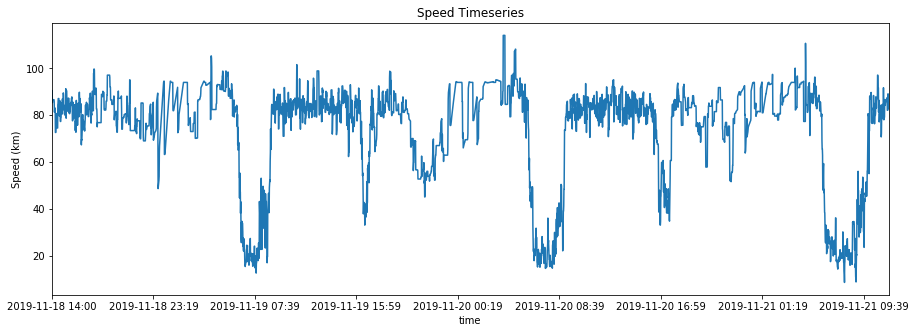

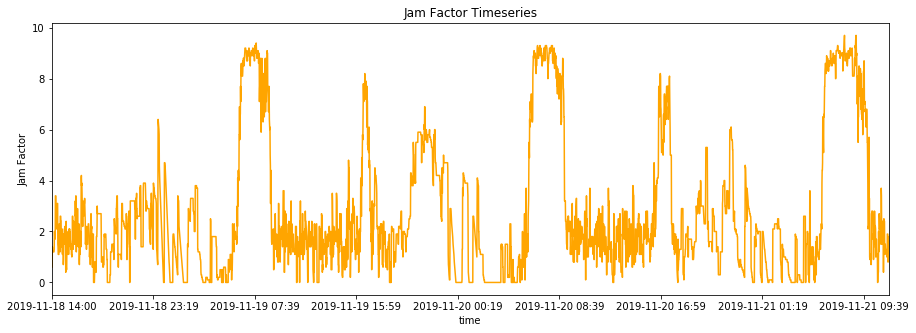

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime

#Gore Highway -Brookstead / Yandillaa
roadworks_timeseries = pd.read_csv('livelinks_here_31862.csv ') 
#frequency
#timeseries_GoreHwy.hist('speed', bins= 5)
jamf = roadworks_timeseries['jamf']
speed = roadworks_timeseries['speed']

#with time domain
here_links_rel_col_timeseries = roadworks_timeseries.set_index('time') #set index

fig, ax = plt.subplots(figsize=(15, 5))
here_links_rel_col_timeseries['speed'].plot()
ax.set_ylabel('Speed (km)')
ax.title.set_text('Speed Timeseries')

fig, ax = plt.subplots(figsize=(15, 5))
here_links_rel_col_timeseries['jamf'].plot(color='orange')
ax.set_ylabel('Jam Factor')
ax.title.set_text('Jam Factor Timeseries')

Forecasting Time series for prediction or a labelling classification task -todo